In [9]:
from vgg_models.vgg import vgg13_bn
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

model = vgg13_bn(pretrained=True)
model.eval() # for evaluation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
# creating an input
#img = torch.zeros((3,224,224))
mean = 0.5
std = 0.03
input = mean + std*torch.randn((3,224,224))

#function that preprocesses the image to be as expected by the network
preprocess = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])
deprocess = transforms.Normalize(mean=[-0.4914/0.2471, -0.4822/0.2435, -0.4465/0.2616], std=[1/0.2471, 1/0.2435, 1/0.2616])

input = preprocess(input)

input_batch = input.unsqueeze(0) # create a mini-batch as expected by the model
input_batch.requires_grad_()

def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

def show_im(batch):
    img = batch.reshape(3,224,224).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))


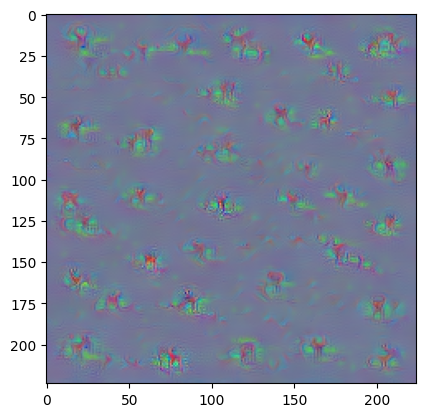

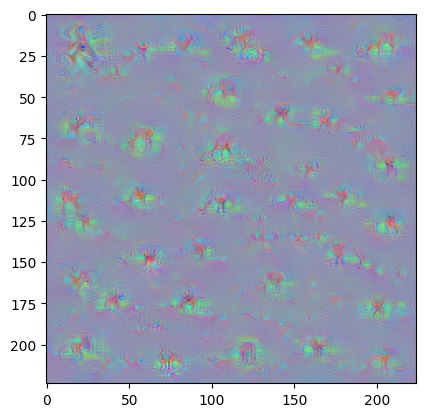

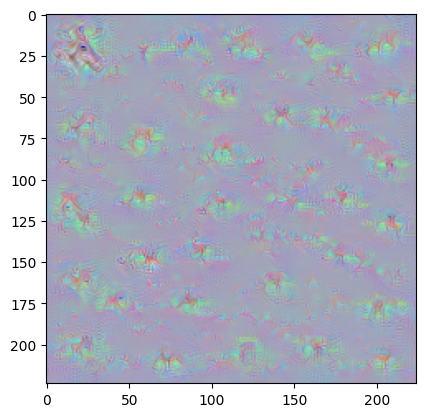

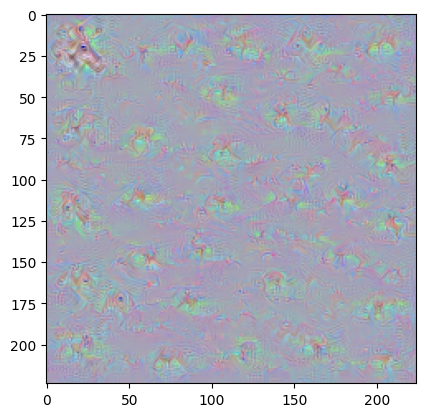

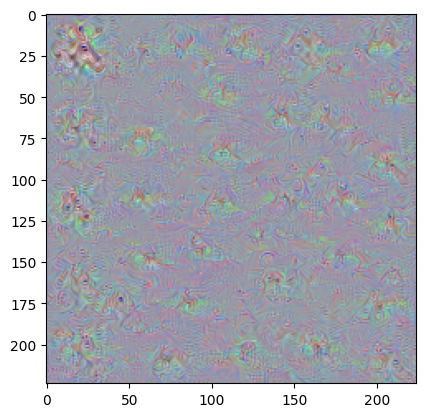

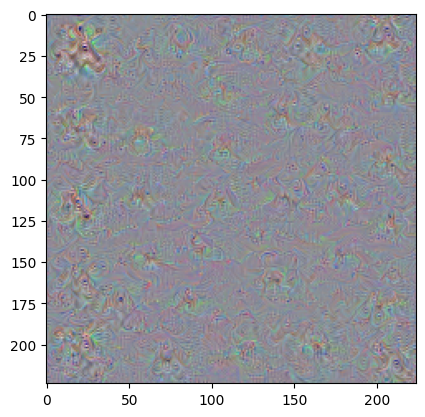

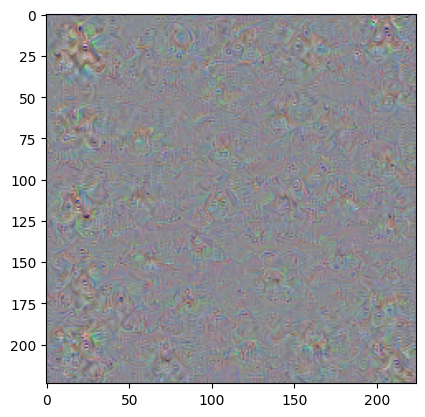

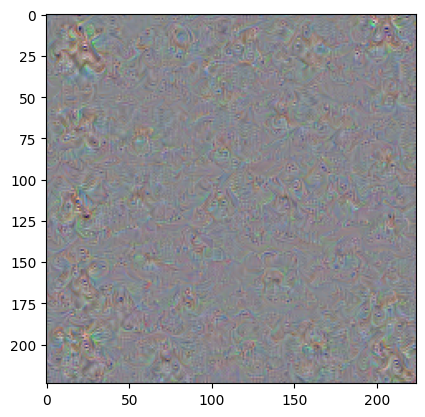

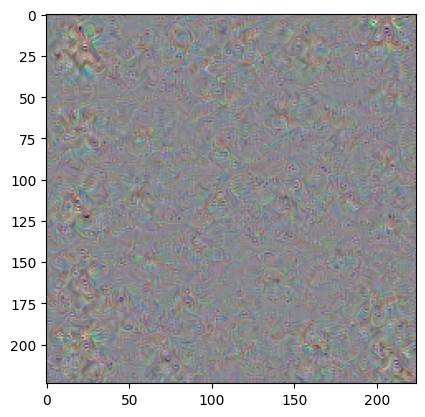

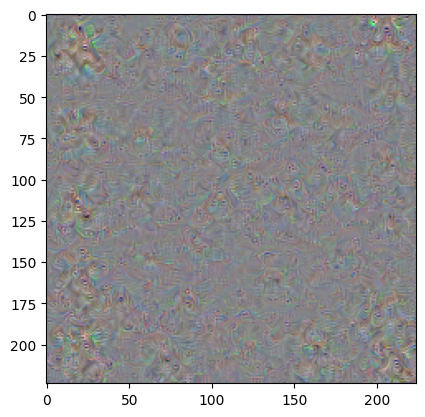

In [5]:
# Class I want to optimize
idx = 4 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks


epochs = 1000
start_step_size = 0.01
end_step_size = 0.01


start_sig = 0.5 #was 1 Having a decaying sigma seems to yield better results
end_sig = 0.05 
jitter = 0 # Jitter doesn't seem to help too much
theta_decay = 0.01 # Theta decay seems to help (0.02 seems good)

num_im_save = 10

checkpoints = []

for epoch in range(epochs):
  
  model.zero_grad()
  if input_batch.grad != None:
    input_batch.grad.zero_()
  y_pred = model.forward(input_batch)

  y_pred[0,idx].backward()

  g = input_batch.grad
  #ox, oy = np.random.randint(-jitter, jitter+1, 2)
  
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input_batch += step_size/np.abs(g).mean() * g

    # input_batch = input_batch.roll( ox, -1) # apply jitter shift
    # input_batch = input_batch.roll( oy, -2)

    #input_batch = input_batch.mul((1.0 - theta_decay)) # weight decay

    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input_batch = blurrer(input_batch)    

  input_batch.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input_batch)
    show_im(input_batch)
    plt.show()



In [9]:
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(torch.argmax(probabilities))
print(torch.max(probabilities))

tensor(2)
tensor(0.9998)


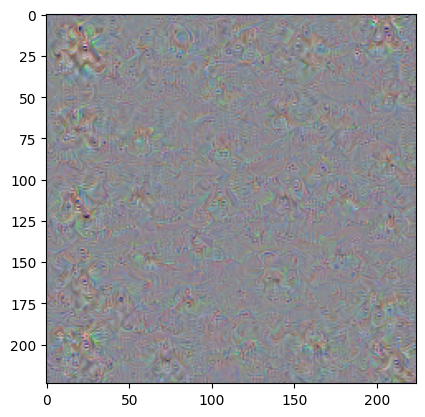

In [10]:
checkpoint_num = 6

show_im(checkpoints[checkpoint_num])

In [11]:
from PIL import Image
import os


img = checkpoints[checkpoint_num].reshape(3,224,224).permute(1,2,0)
img_np = img.detach().numpy()
arr = norm_01(img_np) *255
im = Image.fromarray(arr.astype(np.uint8))

output_directory = './Act_Max_Img/VGG_13bn/'
output_filename = 'class__lr_0.01.jpg'
output_path = output_directory + output_filename
if os.path.isdir('output_path'):
    print("file already exists")
else;
    im.save(output_path)